In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
N = 16
two_N = 32
nearest_square = 36
sqrt_N = 6

n = torch.arange(nearest_square)
omegas = torch.exp(2j * torch.pi * n / nearest_square)

In [60]:
omegas

tensor([ 1.0000e+00+0.0000e+00j,  9.8481e-01+1.7365e-01j,
         9.3969e-01+3.4202e-01j,  8.6603e-01+5.0000e-01j,
         7.6604e-01+6.4279e-01j,  6.4279e-01+7.6604e-01j,
         5.0000e-01+8.6603e-01j,  3.4202e-01+9.3969e-01j,
         1.7365e-01+9.8481e-01j, -4.3711e-08+1.0000e+00j,
        -1.7365e-01+9.8481e-01j, -3.4202e-01+9.3969e-01j,
        -5.0000e-01+8.6603e-01j, -6.4279e-01+7.6604e-01j,
        -7.6604e-01+6.4279e-01j, -8.6603e-01+5.0000e-01j,
        -9.3969e-01+3.4202e-01j, -9.8481e-01+1.7365e-01j,
        -1.0000e+00-8.7423e-08j, -9.8481e-01-1.7365e-01j,
        -9.3969e-01-3.4202e-01j, -8.6603e-01-5.0000e-01j,
        -7.6604e-01-6.4279e-01j, -6.4279e-01-7.6604e-01j,
        -5.0000e-01-8.6603e-01j, -3.4202e-01-9.3969e-01j,
        -1.7365e-01-9.8481e-01j,  1.1925e-08-1.0000e+00j,
         1.7365e-01-9.8481e-01j,  3.4202e-01-9.3969e-01j,
         5.0000e-01-8.6603e-01j,  6.4279e-01-7.6604e-01j,
         7.6604e-01-6.4279e-01j,  8.6603e-01-5.0000e-01j,
         9.396

In [5]:
def polystr(poly):
    N = len(poly)
    poly_str = ''
    for i in range(N):
        if i == N - 1:
            poly_str += str(poly[i])
        else:
            poly_str += f'{round(poly[i], 2)}x^{N-i-1} + '
    return poly_str

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.cfloat)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.cfloat)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N].to(torch.float)

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

In [22]:
def polystr(poly):
    N = len(poly)
    poly_str = ''
    for i in range(N):
        if i == N - 1:
            poly_str += f'{round(poly[i], 2)}'
        else:
            poly_str += f'{round(poly[i], 2)}x^{N-i-1} + '
    return poly_str

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.cfloat)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.cfloat)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N].to(torch.float)

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

In [53]:
def new_monarch(nearest_square, sqrt_N):
    r_polys = [
        [
            torch.rand(sqrt_N - i).numpy().tolist() if i == 0 else
            [0] * i + torch.rand(sqrt_N - i).numpy().tolist()
            for i in range(sqrt_N)
        ]
        for j in range(sqrt_N)
    ]
    l_polys = [
        torch.rand(sqrt_N - i).numpy().tolist() if i == 0 else
        [0] * i + torch.rand(sqrt_N - i).numpy().tolist()
        for i in range(sqrt_N)
    ]
    R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

    for i in range(sqrt_N):
        block = torch.zeros(sqrt_N, sqrt_N)
        for j in range(sqrt_N):
            block[:, j] = torch.tensor(np.polyval(r_polys[i][j], omegas[::sqrt_N]))
        R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = block.T
    for j in range(sqrt_N):
        for i in range(sqrt_N):
            L[i * sqrt_N:(i + 1) * sqrt_N, j * sqrt_N:(j + 1) * sqrt_N] = torch.diag(torch.tensor(np.polyval(l_polys[j], omegas[i * sqrt_N:(i + 1) * sqrt_N])))
    M = L @ R

    return L, R, M, r_polys, l_polys

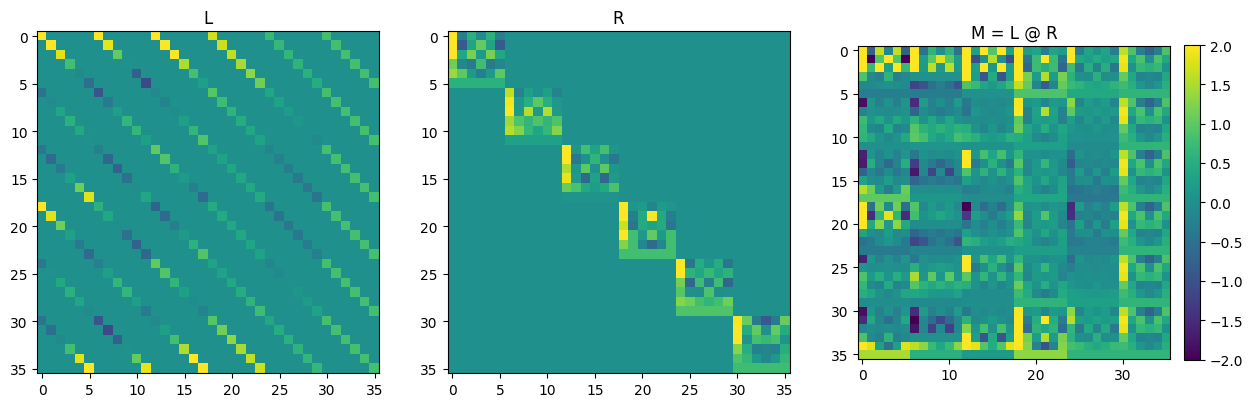

In [54]:
L, R, M, r_polys, l_polys = new_monarch(nearest_square, sqrt_N)
plot_monarch(L.real, R.real, M.real)

In [55]:
print('l_polys:')
for i, poly in enumerate(l_polys):
    print(f'l_{i}\t=\t{polystr(poly)}')

print('r_polys:')
for j1, poly in enumerate(r_polys):
    for j0, rpoly in enumerate(poly):
        print(f'r_{j1},{j0}\t=\t{polystr(rpoly)}')

l_polys:
l_0	=	0.0x^5 + 1.0x^4 + 0.17x^3 + 0.97x^2 + 0.29x^1 + 0.55
l_1	=	0x^5 + 0.94x^4 + 0.49x^3 + 0.36x^2 + 0.3x^1 + 0.06
l_2	=	0x^5 + 0x^4 + 0.95x^3 + 0.37x^2 + 0.78x^1 + 0.64
l_3	=	0x^5 + 0x^4 + 0x^3 + 0.31x^2 + 0.63x^1 + 0.78
l_4	=	0x^5 + 0x^4 + 0x^3 + 0x^2 + 0.57x^1 + 0.11
l_5	=	0x^5 + 0x^4 + 0x^3 + 0x^2 + 0x^1 + 0.82
r_polys:
r_0,0	=	0.86x^5 + 0.75x^4 + 0.93x^3 + 0.45x^2 + 0.21x^1 + 0.75
r_0,1	=	0x^5 + 0.88x^4 + 0.69x^3 + 0.58x^2 + 0.21x^1 + 0.48
r_0,2	=	0x^5 + 0x^4 + 0.58x^3 + 0.2x^2 + 0.36x^1 + 0.88
r_0,3	=	0x^5 + 0x^4 + 0x^3 + 0.79x^2 + 0.18x^1 + 0.16
r_0,4	=	0x^5 + 0x^4 + 0x^3 + 0x^2 + 0.84x^1 + 0.57
r_0,5	=	0x^5 + 0x^4 + 0x^3 + 0x^2 + 0x^1 + 0.56
r_1,0	=	0.21x^5 + 0.44x^4 + 0.43x^3 + 0.08x^2 + 0.16x^1 + 0.29
r_1,1	=	0x^5 + 0.07x^4 + 0.29x^3 + 0.68x^2 + 0.18x^1 + 0.7
r_1,2	=	0x^5 + 0x^4 + 0.82x^3 + 0.25x^2 + 0.26x^1 + 0.99
r_1,3	=	0x^5 + 0x^4 + 0x^3 + 0.27x^2 + 0.27x^1 + 0.9
r_1,4	=	0x^5 + 0x^4 + 0x^3 + 0x^2 + 0.59x^1 + 0.96
r_1,5	=	0x^5 + 0x^4 + 0x^3 + 0x^2 + 0x^1 + 0.29
r

In [58]:
# test causality by changing the last element of u, and seeing if the output changes

u = torch.randn(N)
k = torch.randn(N)

M1 = M
M2 = M
M3 = torch.linalg.inv(M)

y = new_monarch_fft_conv(u, k, N, M1, M2, M3)

new_u = torch.randn(N)
u_changed = torch.clone(u)

new_ys = []

for i in range(1, N + 1):
    u_changed[-i] = new_u[-i]
    new_ys.append(new_monarch_fft_conv(u_changed, k, N, M1, M2, M3))

new_ys = torch.stack(new_ys)

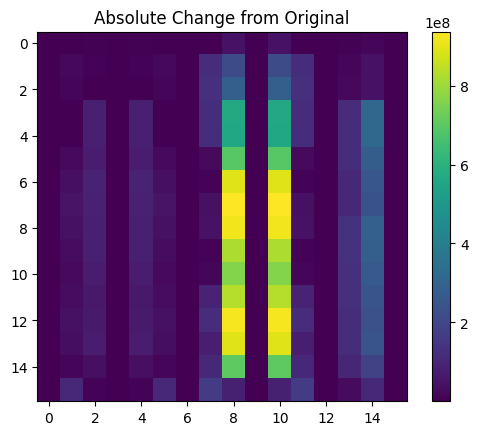

In [59]:
plt.title('Absolute Change from Original')

plt.imshow(torch.abs(new_ys - y))
plt.colorbar()